# Environment

In [1]:
import gym
import tensorflow as tf
from tensorflow import keras
import random
import numpy as np
import datetime as dt
import math

import pandas as pd
import seaborn as sns
sns.set()


import matplotlib.pyplot as plt
from gridworld import SimpleGrid


class custom_env:

    def __init__(self, env_name, param={}):
        # Initialize atributes
        self.env_name = env_name    # name of environment
        self.param = param          # dictionarry of environment parameters

        if (self.env_name == "SimpleGrid"):
            self.env = SimpleGrid(self.param["grid_size"],
                                  block_pattern=self.param["pattern"],
                                  obs_mode=self.param["obs_mode"])

            self.action_space = gym.spaces.Discrete(4)
            self.env.reset(
                agent_pos=self.param["agent_pos"], goal_pos=self.param["goal_pos"])

            self.state_type = "Discrete"
            self.observation_space = gym.spaces.Discrete(
                self.param["grid_size"]**2)
            
            print("self.env", self.env)

        if (self.env_name.split("_")[0] == "gym"):
            gym_name = "_".join(self.env_name.split("_")[1:])
            self.env = gym.make(gym_name)
            self.action_space = self.env.action_space
            if (type(self.env.observation_space) == gym.spaces.discrete.Discrete):
                self.observation_space = self.env.observation_space
                self.state_type = "Discrete"
                                
            else:
                self.state_type = "Continue"

        observation = self.reset()
        
        if self.state_type == "Discrete":
            self._state_dim = self.observation_space.n
        else:
            self._state_dim = len(observation)

    def reset(self):
        
        
        if self.state_type == "Discrete":
            if (self.env_name == "SimpleGrid"):
                self.env.reset(agent_pos=self.param["agent_pos"], goal_pos=self.param["goal_pos"])
                n = self.observation_space.n
                return_reset = np.array(keras.utils.to_categorical(
                    self.env.observation,   
                    num_classes=n)).reshape(n)
            else : 
                
                state_res = self.env.reset()
                
                n = self.observation_space.n
                return_reset = np.array(keras.utils.to_categorical(
                    state_res, 
                    num_classes=n)).reshape(n)
                
        else : 
            return_reset = self.env.reset()
        
        return return_reset

    def step(self, action):
        
                    
        if self.state_type == "Discrete":
            
            if (self.env_name == "SimpleGrid"):
                reward = self.env.step(action)
                done = self.env.done
                info = ""
                n = self.observation_space.n
                next_state = np.array(keras.utils.to_categorical(
                    self.env.observation, 
                    num_classes=n)).reshape(n)

                return_env = np.array(next_state), reward, done, info
            
            else :
            
                next_state, reward, done, info = self.env.step(action)

                n = self.observation_space.n
                next_state = np.array(keras.utils.to_categorical(
                    next_state, 
                    num_classes=n)).reshape(n)

                return_env = np.array(next_state), reward, done, info
            
        else:
            return_env = self.env.step(action)

        
        return return_env
        
        
    def render(self):
        if (self.env_name == "SimpleGrid"):
            
            fig = plt.figure(figsize=(5, 5))         
            plt.imshow(self.env.grid)
            plt.show()
        if (self.env_name.split("_")[0] == "gym"):
            self.env.render()

        
    def close(self):
        if (self.env_name.split("_")[0] == "gym"):
            self.env.close()


# Agent

In [2]:
class Agent:
    def __init__(self, enviroment, param={}):

        self.param = param
        self._action_size = enviroment.action_space.n
        self._state_dim = env._state_dim

        
        self.primary_network = keras.Sequential()
        self.primary_network.add(keras.layers.InputLayer(input_shape=(self._state_dim,)))
        self.primary_network.add(keras.layers.Dense(30, activation='relu'))
        self.primary_network.add(keras.layers.Dense(30, activation='relu'))
        self.primary_network.add(keras.layers.Dense(self._action_size))
        
        
        self.target_network = keras.models.clone_model(self.primary_network)

        self.primary_network.compile(
            optimizer=self.param["optimizer"], loss='mse')

         # Initialize policy
        if (param_agent["policy"]["type"][0] == "eps-greedy"):
            self.policy = "eps-greedy"

            if (param_agent["policy"]["type"][1] == "exponantial"):
                self.pi_1 = "exponantial"

                self.epsilon = self.param["policy"][self.policy][self.pi_1]["eps_max"]
                self.eps_max = self.param["policy"][self.policy][self.pi_1]["eps_max"]
                self.eps_min = self.param["policy"][self.policy][self.pi_1]["eps_min"]
                self._lambda = self.param["policy"][self.policy][self.pi_1]["lambda"]

            if (param_agent["policy"]["type"][1] == "constant"):
                self.pi_1 = "constant"
                self.epsilon = self.param["policy"][self.policy][self.pi_1]["eps"]

    def choose_action(self, state, primary_network, steps):
        if (self.policy == "eps-greedy"):
            if (self.pi_1 == "exponantial"):
                self.epsilon = self.eps_min + \
                    (self.eps_max - self.eps_min) * \
                    math.exp(-self._lambda * steps)

            if random.random() < self.epsilon:
                return random.randint(0, self._action_size - 1), self.epsilon
            else:
                return np.argmax(primary_network(state.reshape(1, -1))), self.epsilon

    def train(self, primary_network, memory, target_network=None):
        if memory.num_samples < BATCH_SIZE * 3:
            return 0
        batch = memory.sample(BATCH_SIZE)
        
        states = np.array([val[0] for val in batch])

        actions = np.array([val[1] for val in batch])
        rewards = np.array([val[2] for val in batch])
        next_states = np.array([(np.zeros(self._state_dim)
                                 if val[3] is None else val[3]) for val in batch])

        prim_qt = primary_network(states)
        prim_qtp1 = primary_network(next_states)

        # copy the prim_qt tensor into the target_q tensor - 
#         we then will update one index corresponding to the max action
        target_q = prim_qt.numpy()

        updates = rewards.astype(np.float32)

        valid_idxs = np.array(next_states).sum(axis=1) != 0

        batch_idxs = np.arange(BATCH_SIZE)


        if target_network is None:
            updates[valid_idxs] += self.param["gamma"] * \
                np.amax(prim_qtp1.numpy()[valid_idxs, :], axis=1)
        else:

            prim_action_tp1 = np.argmax(prim_qtp1.numpy(), axis=1)
            q_from_target = target_network(next_states)

            updates[valid_idxs] += self.param["gamma"] * q_from_target.numpy()[
                batch_idxs[valid_idxs],
                prim_action_tp1[valid_idxs]]
            
            

        target_q[batch_idxs, actions] = updates
        loss = primary_network.train_on_batch(states, target_q)

        if target_network is not None:
            # update target network parameters slowly from primary network
            
            for t, e in zip(target_network.trainable_variables, primary_network.trainable_variables):
                t.assign(t * (1 - self.param["tau"]) + e * self.param["tau"])

        return loss



# Storage

In [3]:

class Memory:
    def __init__(self, max_memory):
        self._max_memory = max_memory
        self._samples = []

    def add_sample(self, sample):
        self._samples.append(sample)
        if len(self._samples) > self._max_memory:
            self._samples.pop(0)

    def sample(self, no_samples):
        if no_samples > len(self._samples):
            return random.sample(self._samples, len(self._samples))
        else:
            return random.sample(self._samples, no_samples)

    @property
    def num_samples(self):
        return len(self._samples)


# Parameters

In [4]:

param_env = {
    "agent_pos":None, 
    "goal_pos":[0, 7-1],
    "grid_size" : 7,
    "pattern":"random",
    "obs_mode":"index",
}
env_name = "SimpleGrid"
env = custom_env(env_name, param_env)

# env_name = "gym_NChain-v0"
# env = custom_env(env_name)

# env_name = "gym_CartPole-v1"
# env = custom_env(env_name)

    
STORE_PATH = '.'

BATCH_SIZE = 32
RANDOM_REWARD_STD = -1.0

param_agent = {
    "optimizer": keras.optimizers.Adam(),
    "policy": {
        "type": ["eps-greedy", "exponantial"],
        "eps-greedy": {
            "exponantial": {
                "eps_max": 1.,
                "eps_min": 0.01,
                "lambda": 0.0005
            },
            "constant": {
                "eps": 0.01
            }
        }
    },
    "gamma": 0.95,
    "tau": 0.08,
}


memory = Memory(500000)

agent = Agent(env, param_agent)

num_episodes = 200
render = False
# train_writer = tf.summary.create_file_writer(
#     STORE_PATH + f"/DoubleQ_{dt.datetime.now().strftime('%d%m%Y%H%M')}")
double_q = True




self.env <gridworld.SimpleGrid object at 0x7f9027f03cd0>


In [5]:
state = env.reset()
action = random.randint(0, env.action_space.n - 1)

steps=0
action, eps = agent.choose_action(state, agent.primary_network, steps)
next_state, reward, done, info = env.step(action)

state, action, next_state, reward, done, info


(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32),
 2,
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32),
 0.0,
 False,
 '')

In [6]:
agent.primary_network.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                1500      
_________________________________________________________________
dense_1 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 124       
Total params: 2,554
Trainable params: 2,554
Non-trainable params: 0
_________________________________________________________________


# Run

In [7]:
data_train = []

steps = 0
render = False

reward_cumul = 0

for i in range(num_episodes):
    state = env.reset()

    reward_ep_cumul = 0
    cnt = 0
    avg_loss = 0
    while True:
        if render:
            env.render()

        action, eps = agent.choose_action(state, agent.primary_network, steps)
        next_state, reward, done, info = env.step(action)

        if RANDOM_REWARD_STD > 0:
            reward = np.random.normal(1.0, RANDOM_REWARD_STD)

#         print("state: ", state)
#         print("action : ", action)
#         print("reward: ", reward)
#         print("next_state : ", next_state)
#         print("done : ",  done)
#         print("-------------------- \n")

        reward_ep_cumul += reward
        reward_cumul += reward
        if done:
            next_state = None
        # store in memory
        memory.add_sample((state, action, reward, next_state))

        loss = agent.train(agent.primary_network, memory,
                           agent.target_network if double_q else None)
        avg_loss += loss

        state = next_state

        # exponentially decay the eps value
        steps += 1
#         eps = MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * math.exp(-LAMBDA * steps)

        if done:
            if cnt != 0:
                avg_loss /= cnt
            else:
                avg_loss = 0
            result = [i, cnt, steps, reward_ep_cumul,
                      reward_cumul, avg_loss, eps]

            print("Episode: {:03d}, step: {:03d}, cumul_step: {:04d}, Reward: {:3.1f}, Reward_cumul: {:3.1f}, avg loss: {:0.4f}, eps: {:0.4f} ".format(*result))

            data_train.append(result)
#             with train_writer.as_default():
#                 tf.summary.scalar('reward', cnt, step=i)
#                 tf.summary.scalar('avg loss', avg_loss, step=i)
            break

        cnt += 1

Episode: 000, step: 451, cumul_step: 0452, Reward: 1.0, Reward_cumul: 1.0, avg loss: 0.0002, eps: 0.8001 
Episode: 001, step: 001, cumul_step: 0454, Reward: 1.0, Reward_cumul: 2.0, avg loss: 0.0003, eps: 0.7993 
Episode: 002, step: 046, cumul_step: 0501, Reward: 1.0, Reward_cumul: 3.0, avg loss: 0.0002, eps: 0.7810 
Episode: 003, step: 050, cumul_step: 0552, Reward: 1.0, Reward_cumul: 4.0, avg loss: 0.0004, eps: 0.7616 
Episode: 004, step: 000, cumul_step: 0553, Reward: 1.0, Reward_cumul: 5.0, avg loss: 0.0000, eps: 0.7612 
Episode: 005, step: 068, cumul_step: 0622, Reward: 1.0, Reward_cumul: 6.0, avg loss: 0.0002, eps: 0.7357 
Episode: 006, step: 031, cumul_step: 0654, Reward: 1.0, Reward_cumul: 7.0, avg loss: 0.0002, eps: 0.7242 
Episode: 007, step: 016, cumul_step: 0671, Reward: 1.0, Reward_cumul: 8.0, avg loss: 0.0002, eps: 0.7182 
Episode: 008, step: 048, cumul_step: 0720, Reward: 1.0, Reward_cumul: 9.0, avg loss: 0.0003, eps: 0.7010 
Episode: 009, step: 018, cumul_step: 0739, Rew

Episode: 079, step: 013, cumul_step: 1797, Reward: 1.0, Reward_cumul: 80.0, avg loss: 0.0000, eps: 0.4133 
Episode: 080, step: 003, cumul_step: 1801, Reward: 1.0, Reward_cumul: 81.0, avg loss: 0.0000, eps: 0.4125 
Episode: 081, step: 013, cumul_step: 1815, Reward: 1.0, Reward_cumul: 82.0, avg loss: 0.0000, eps: 0.4097 
Episode: 082, step: 017, cumul_step: 1833, Reward: 1.0, Reward_cumul: 83.0, avg loss: 0.0000, eps: 0.4061 
Episode: 083, step: 013, cumul_step: 1847, Reward: 1.0, Reward_cumul: 84.0, avg loss: 0.0000, eps: 0.4034 
Episode: 084, step: 009, cumul_step: 1857, Reward: 1.0, Reward_cumul: 85.0, avg loss: 0.0000, eps: 0.4014 
Episode: 085, step: 007, cumul_step: 1865, Reward: 1.0, Reward_cumul: 86.0, avg loss: 0.0000, eps: 0.3998 
Episode: 086, step: 020, cumul_step: 1886, Reward: 1.0, Reward_cumul: 87.0, avg loss: 0.0000, eps: 0.3958 
Episode: 087, step: 011, cumul_step: 1898, Reward: 1.0, Reward_cumul: 88.0, avg loss: 0.0000, eps: 0.3934 
Episode: 088, step: 024, cumul_step: 

Episode: 160, step: 010, cumul_step: 2613, Reward: 1.0, Reward_cumul: 161.0, avg loss: 0.0000, eps: 0.2782 
Episode: 161, step: 006, cumul_step: 2620, Reward: 1.0, Reward_cumul: 162.0, avg loss: 0.0000, eps: 0.2773 
Episode: 162, step: 002, cumul_step: 2623, Reward: 1.0, Reward_cumul: 163.0, avg loss: 0.0000, eps: 0.2769 
Episode: 163, step: 005, cumul_step: 2629, Reward: 1.0, Reward_cumul: 164.0, avg loss: 0.0000, eps: 0.2761 
Episode: 164, step: 010, cumul_step: 2640, Reward: 1.0, Reward_cumul: 165.0, avg loss: 0.0000, eps: 0.2746 
Episode: 165, step: 005, cumul_step: 2646, Reward: 1.0, Reward_cumul: 166.0, avg loss: 0.0000, eps: 0.2738 
Episode: 166, step: 012, cumul_step: 2659, Reward: 1.0, Reward_cumul: 167.0, avg loss: 0.0000, eps: 0.2721 
Episode: 167, step: 008, cumul_step: 2668, Reward: 1.0, Reward_cumul: 168.0, avg loss: 0.0000, eps: 0.2709 
Episode: 168, step: 007, cumul_step: 2676, Reward: 1.0, Reward_cumul: 169.0, avg loss: 0.0000, eps: 0.2699 
Episode: 169, step: 001, cum

In [8]:
data_train_df = pd.DataFrame(data_train, columns=[ "Episode", "Step", "cum_step", "Reward", "Reward_cum", "Avg_loss", "Eps"])
data_train_df

,Episode,Step,cum_step,Reward,Reward_cum,Avg_loss,Eps
0,0,451,452,1.0,1.0,2.057927e-04,0.800136
1,1,1,454,1.0,2.0,2.909589e-04,0.799346
2,2,46,501,1.0,3.0,1.756296e-04,0.781013
3,3,50,552,1.0,4.0,4.466168e-04,0.761601
4,4,0,553,1.0,5.0,0.000000e+00,0.761225
...,...,...,...,...,...,...,...
195,195,7,2905,1.0,196.0,3.323612e-08,0.241761
196,196,5,2911,1.0,197.0,6.975129e-08,0.241066
197,197,1,2913,1.0,198.0,3.313448e-08,0.240835
198,198,19,2933,1.0,199.0,5.184259e-08,0.238539


<AxesSubplot:xlabel='cum_step', ylabel='Eps'>

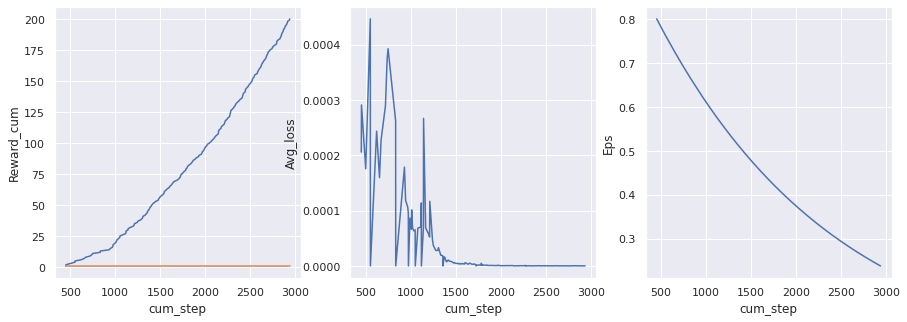

<Figure size 360x360 with 0 Axes>

In [9]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3,figsize=(15, 5))


plt.figure(figsize=(5, 5))
sns.lineplot(x="cum_step", y="Reward_cum", data=data_train_df, ax = axs[0] )
sns.lineplot(x="cum_step", y="Reward", data=data_train_df, ax = axs[0] )
sns.lineplot(x="cum_step", y="Avg_loss", data=data_train_df, ax = axs[1] )
sns.lineplot(x="cum_step", y="Eps", data=data_train_df, ax = axs[2] )


# See results

In [10]:
# render = True
# steps = 100000 # on simule un step pour avoir un espilon minimum

# test_num_episodes = 10



# for i in range(test_num_episodes):
#     state = env.reset()
#     cnt = 0
#     avg_loss = 0
#     while True:
#         if render:
#             env.render()
# #         action, eps = random.randint(0, env.action_space.n - 1), 0.01
#         action, eps = agent.choose_action(state, agent.primary_network, steps)
    
#         next_state, reward, done, info = env.step(action)
        
# #         reward = np.random.normal(1.0, RANDOM_REWARD_STD)
#         if done:
#             next_state = None

#         state = next_state

#         if done:
#             if cnt != 0 : avg_loss /= cnt
#             else : avg_loss = 0
#             result = [i,cnt,steps, reward_ep_cumul, reward_cumul,avg_loss,eps]
            

#             print("Episode: {:03d}, step: {:03d}, cumul_step: {:04d}, Reward: {:3.1f}, Reward_cumul: {:3.1f}, avg loss: {:0.4f}, eps: {:0.4f} ".format(*result))
            
#             break

#         cnt += 1
# print("step", cnt)
# env.close()

In [11]:
env.close()